# Estimating the state of a static system {-}

Just to show the idea behind the filter being an recursive algorithm, let's start with the simple example of recursively computing the *mean* and *standard error* of a random set of numbers. Assume that we have a system that doesn't change with time, thus being what we would call a *static system*. In the vocabulary of the Kalman Filter we would say that the systems dynamic model is just a constant.

The measurement in this example is the distance to a wall measured by a robot being at rest. The distance is measured repeatedly over time with a laser scanner. Within this simple 1D world frame, the distance is equal to the position of the robot.

![laserscan](fig/laserscan.png)

For simplicity, since we do not know anything about any digital filters yet, we choose first to estimate the position as the sample mean of all the measurements. This will now become our *measurement model*, i.e. how the measurements relates to the *system state*. It will look something like this:

$$
\bar x = \frac{1}{n} \sum_{i=1}^n x_i
$$

To perform an implementation in Python, let us just make a list of 10 random numbers and set them to be our measurements from the laser scanner.

In [1]:
# Compute sample mean, standard deviation and standard error

# Import
from numpy import mean, std, sqrt

# Measurements
x = [51.34, 48.17, 49.02, 50.97, 51.23, 50.72, 48.95, 49.45, 52.07, 50.52]

# Number of measurements
N = len(x)

mu = mean(x)
sd = std(x, ddof=1)
se = sd/sqrt(N)

print(f"Estimated position: {mu:5.2f} m")
print(f"Standard deviation: {sd:5.2f} m")
print(f"Standard error:     {se:5.2f} m")

Estimated position: 50.24 m
Standard deviation:  1.27 m
Standard error:      0.40 m


This is a perfectly reasonable estimate of the unknown position and the corresponding precision, however the main problem is that we have to wait until all the measurements are available before we can compute the position estimate. Usually we do not want to wait for all the measurements to be available, instead we want to calculate the position estimate as soon as the measurements arrive from the laser scanner.

## Recursive Mean and Variance {-}
To do this we need to modify the equation a little bit to be able to update the current position estimate as the new measurements arrive. So, let us derive the mean value from the definition above:

$$
  \bar{x}_{n} = \bar{x}_{n-1} + \frac{1}{n}(x_n-\bar{x}_{n-1})
$$

Voila! now we have a recursive algorithm to compute the mean position. As seen above, the mean can now be calculated recursively as the previous mean plus the weighted contribution of the new measurement. With Kalman Filter notation, the weight $\frac{1}{n}$ is called "gain" and the measurement residual $(x_n-\bar{x}_{n-1})$ is called "innovation".

Let us first try our new algorithm with the measurements from the laser scanner.

In [2]:
# Compute recursive mean

# Measurements
x = [51.34, 48.17, 49.02, 50.97, 51.23, 50.72, 48.95, 49.45, 52.07, 50.52]

# Inital estimate
x_bar = 0

# Number of measurements
N = len(x)

# Initialize result lists
rmu = []; meas = []

# Main loop
for n in range(1, N + 1):
    
    # Previous value
    x_barp = x_bar
    
    # Recursive mean
    x_bar = x_barp + 1/n*(x[n - 1] - x_barp)
    
    # Accumulate result lists
    rmu.append(x_bar)
    meas.append(x[n - 1])

print("Measurement        : " + ' '.join(f'{meas:.2f}' for meas in meas))
print("Estimated position : " + ' '.join(f'{rmu:.2f}' for rmu in rmu))

Measurement        : 51.34 48.17 49.02 50.97 51.23 50.72 48.95 49.45 52.07 50.52
Estimated position : 51.34 49.76 49.51 49.88 50.15 50.24 50.06 49.98 50.21 50.24


Unlike the sample mean, the recursive mean can make use of the new measurements once they are available and provide an estimate of the unknown position. Also note that, in the end when all the measurements are available, the sample mean and the recursive mean will, as expected, provide the exact same estimate of the unknown position.

### Plotting the results {-}
When working with recursive algorithms it is often much easier to get an overall impression of the filter performance by plotting the estimated values over time. While it might seem unnecessary to plot the results with this simple example, it is still good practice to do so and it will help you solve many of the problems you eventually will run into as the datasets becomes much larger.

So, lets briefly show how to plot the main results from this simple example.

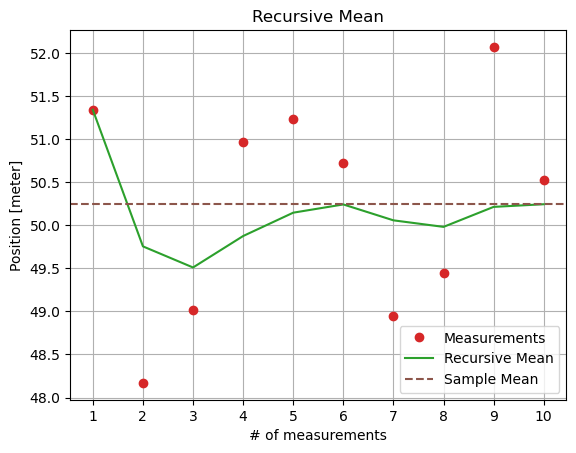

In [3]:
# Plotting the results

# Import
from numpy import arange
import matplotlib.pyplot as plt

# Defining x-axis
n = arange(1, N + 1)

# Plot result
plt.title("Recursive Mean")
plt.plot(n, meas, color='tab:red', marker='o', linestyle='none', label='Measurements')
plt.plot(n, rmu, color='tab:green', label='Recursive Mean')
plt.axhline(y=x_bar, color='tab:brown', linestyle='dashed', label='Sample Mean')
plt.xlabel("# of measurements"); plt.xticks(n)
plt.ylabel("Position [meter]")
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Error Analysis {-}
The square root of the *variance* is called the *standard deviation*. Both quantities are very useful statistical units and also quite similar as they both contain information about the signal noise. However, note that only standard deviation will have the same units as the signal itself, thus it will usually be easier to interpret when quantifying noise.

Another important quantity to compute the so called *standard error*. This is the standard deviation of the estimated mean position that we just computed. Note that usually we cannot compute the true position error as this would require knowledge of the true position, which we do not have. However, let us for now define $\bar{x}_n$ to be our "true" position and begin with defining the sample *variance*.

$$
s_n^2 = \frac{1}{n - 1} \sum_{i=1}^n (x_i - \bar{x}_n)^2
$$

Let us then derive the recursive variance from the definition.

$$
s_n^2 = s_{n-1}^2 + \frac{1}{n}(x_n - \bar{x}_{n-1})^2 - \frac{1}{n-1}s_{n-1}^2
$$


Now that we have the sample variance, it is straigth forward to compute the standard error as the standard deviation divided by the square root of the number of observations.

$$
\sigma_{\bar{x}_n} = \frac{s_n}{\sqrt{n}}
$$

Now let us plot the standard deviation together with the standard error for the estimated position.

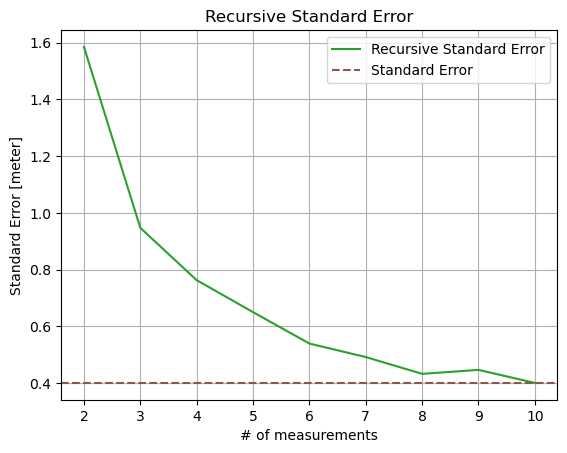

Est standard deviation : 1.59 0.95 0.76 0.65 0.54 0.49 0.43 0.45 0.40


In [4]:
# Import
from numpy import arange, sqrt
import matplotlib.pyplot as plt

# Measurements
x = [51.34, 48.17, 49.02, 50.97, 51.23, 50.72, 48.95, 49.45, 52.07, 50.52]

# Inital estimate
x_bar = 0; s2 = 0

# Number of measurements
N = len(x)

# Initialize result lists
rse = []

# Main loop
for n in range(1, N + 1):
    
    # Previous values
    x_barp = x_bar
    s2p = s2
    
    # Recursive mean
    x_bar = x_barp + 1/n*(x[n - 1] - x_barp)
    
    if n > 1:
        
        # Recursive variance
        s2 = s2p + 1/n*(x[n - 1] - x_barp)**2 - 1/(n - 1)*s2p
        
        # Accumulate result lists
        rse.append(sqrt(s2/n))
                         
# Defining x-axis
n = arange(2, N + 1)

# Plot results
plt.title("Recursive Standard Error")
plt.plot(n, rse, color='tab:green', label='Recursive Standard Error')
plt.axhline(y=se, color='tab:brown', linestyle='dashed', label='Standard Error')
plt.xlabel("# of measurements")
plt.ylabel('Standard Error [meter]')
plt.legend(loc='upper right')
plt.grid()
plt.show()

print("Est standard deviation : " + ' '.join(f'{rse:.2f}' for rse in rse))

Note how the estimated error converge towards the standard error as more measurements contributes to compute the sample mean. In order to illustrate both the estimated values together with their corresponding errors, it is sometimes convenient to plot all the information together in the same plot.

It may look something like this.

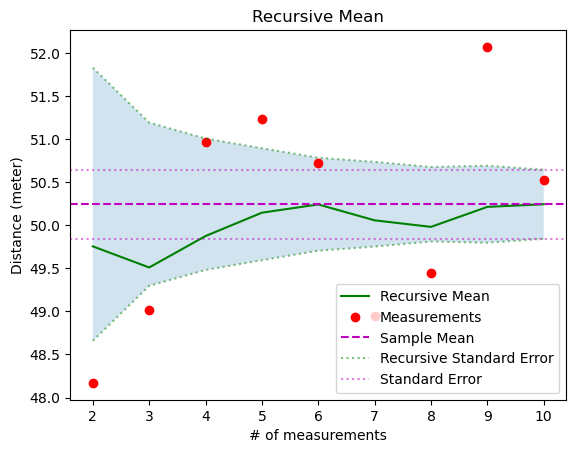

In [5]:
# Import
from numpy import negative
import matplotlib.pyplot as plt

# Plot results
plt.title("Recursive Mean")
plt.plot(n, rmu[1:], color='g', label='Recursive Mean')
plt.plot(n, meas[1:], color='r', marker='o', linestyle='none', label='Measurements')
plt.axhline(y=mu, color='m', linestyle='dashed', label='Sample Mean')
plt.xlabel("# of measurements")
plt.ylabel("Distance (meter)")

plt.plot(n, mu + rse, alpha=0.5, color='g', linestyle='dotted', label='Recursive Standard Error')
plt.plot(n, mu + negative(rse), alpha=0.5, color='g', linestyle='dotted')
plt.fill_between(n, mu + rse, mu + negative(rse), alpha=0.2)
plt.axhline(y=mu + se, alpha=0.5, color='m', linestyle='dotted',label='Standard Error')
plt.axhline(y=mu - se, alpha=0.5, color='m', linestyle='dotted')

plt.legend(loc='lower right')
plt.show()